# A. Case

1. Komponen Utama:

Generator (G): Model yang bertujuan untuk menghasilkan gambar palsu yang menyerupai gambar asli dari noise acak.
Discriminator (D): Model yang bertujuan untuk membedakan antara gambar asli dan gambar palsu yang dihasilkan oleh Generator.

2. Proses Kerja:

Generator:

Input: Menerima vektor noise acak.

Proses: Vektor noise diproses melalui beberapa lapisan neural network untuk menghasilkan gambar yang meniru gambar asli dalam dataset pelatihan.

Output: Menghasilkan gambar palsu yang memiliki distribusi yang mirip dengan gambar asli dari dataset pelatihan.

Discriminator:

Input: Menerima gambar, baik dari dataset asli maupun gambar yang dihasilkan oleh Generator.

Proses: Gambar diproses melalui beberapa lapisan neural network untuk menentukan apakah gambar tersebut asli atau palsu.

Output: Menghasilkan nilai probabilitas yang menunjukkan apakah gambar tersebut asli (real) atau palsu (fake).

3. Proses Pelatihan:

Langkah 1: Melatih Generator (G)

Generate Gambar Palsu: Generator menerima vektor noise acak dan menghasilkan gambar palsu.

Discriminator Evaluation: Gambar palsu ini kemudian diberikan ke Discriminator.

Loss Function: Generator loss dihitung berdasarkan seberapa baik gambar palsu dapat menipu Discriminator. Generator diharapkan untuk memaksimalkan kesalahan Discriminator dalam membedakan gambar palsu dari gambar asli.


Langkah 2: Melatih Discriminator (D)

Input Gambar Asli: Discriminator menerima gambar asli dari dataset dan diharapkan untuk mengklasifikasikannya sebagai asli.

Input Gambar Palsu: Discriminator menerima gambar palsu dari Generator dan diharapkan untuk mengklasifikasikannya sebagai palsu.

Loss Function: Discriminator loss dihitung berdasarkan seberapa baik D dapat membedakan antara gambar asli dan palsu. 



4. Tujuan Akhir:

Generator: 
Menjadi sangat baik dalam menghasilkan gambar palsu yang sangat mirip dengan gambar asli sehingga Discriminator tidak bisa membedakan mana yang asli dan mana yang palsu.

Discriminator: 
Menjadi sangat baik dalam membedakan gambar asli dari gambar palsu, meskipun dalam praktiknya, Discriminator tidak boleh menjadi terlalu kuat sehingga Generator tidak bisa belajar dengan baik.

# B. Case

# Load Data

In [1]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torchvision.models import inception_v3
from scipy import linalg

# Load Fashion MNIST data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Filter for T-shirts/tops (label 0) and Trousers (label 1)
train_mask = np.isin(train_labels, [0, 1])
test_mask = np.isin(test_labels, [0, 1])

train_images, train_labels = train_images[train_mask], train_labels[train_mask]
test_images, test_labels = test_images[test_mask], test_labels[test_mask]

# Normalize images to [-1, 1]
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

# Add channel dimension
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

# Print the number of samples for each label in train and test sets
print("Train set:")
print(f"T-shirts/tops (Label 0): {np.sum(train_labels == 0)}")
print(f"Trousers (Label 1): {np.sum(train_labels == 1)}")
print("\nTest set:")
print(f"T-shirts/tops (Label 0): {np.sum(test_labels == 0)}")
print(f"Trousers (Label 1): {np.sum(test_labels == 1)}")

2024-07-07 17:47:03.498416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 17:47:03.498546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 17:47:03.614316: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train set:
T-shirts/tops (Label 0): 6000
Trousers (Label 1): 6000

Test set:
T-shirts/tops (Label 0): 1000
Trousers (Label 1): 1000


Pada kode ini, saya memuat dan memproses dataset Fashion MNIST untuk hanya menyertakan dua kelas: T-shirts/tops (label 0) dan Trousers (label 1). Pertama, saya mengimpor berbagai library yang diperlukan seperti numpy, TensorFlow, PyTorch, dan lain-lain. Saya kemudian memuat dataset Fashion MNIST menggunakan `tf.keras.datasets.fashion_mnist.load_data()`, dan memfilter data pelatihan serta pengujian untuk hanya menyertakan gambar dengan label 0 dan 1. Selanjutnya, saya menormalkan gambar ke rentang [-1, 1] dan menambahkan dimensi channel ke gambar. Terakhir, saya mencetak jumlah sampel untuk setiap label di set pelatihan dan pengujian, memastikan bahwa data sudah terpisah dengan benar.

In [2]:
train_images_tensor = torch.tensor(train_images.transpose((0, 3, 1, 2)), dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images.transpose((0, 3, 1, 2)), dtype=torch.float32) 
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Pada bagian ini, saya mengubah data gambar dan label dari numpy arrays menjadi tensors PyTorch dan menyiapkan DataLoader untuk pelatihan dan pengujian. Saya mengubah data gambar pelatihan (`train_images`) dan pengujian (`test_images`) menjadi tensors dengan mengubah urutan dimensinya menggunakan `.transpose((0, 3, 1, 2))` agar sesuai dengan format PyTorch [batch, channel, height, width], dan mengonversinya ke tipe data `float32`. Saya juga mengonversi label pelatihan (`train_labels`) dan pengujian (`test_labels`) menjadi tipe data `long`. Kemudian, saya membuat dataset PyTorch menggunakan `TensorDataset` dan menyiapkan DataLoader untuk pelatihan (`train_loader`) dengan `batch_size` 64 dan shuffle, serta untuk pengujian (`test_loader`) tanpa shuffle.

# Discriminator & Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, img_size, noise_dim, num_classes):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.label_emb = nn.Embedding(num_classes, noise_dim)
        self.model = nn.Sequential(
            nn.Linear(noise_dim * 2, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, img_size**2),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), 1, self.img_size, self.img_size)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_size, num_classes):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.label_emb = nn.Embedding(num_classes, img_size**2)
        self.model = nn.Sequential(
            nn.Linear(img_size**2 + img_size**2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_emb(labels)
        d_in = torch.cat((img.view(img.size(0), -1), label_input), -1)
        validity = self.model(d_in)
        return validity

Pada bagian ini, saya membuat dua kelas PyTorch, yaitu Generator dan Discriminator, yang digunakan dalam Generative Adversarial Network (cGAN) seusai perintah soal. Generator menerima ukuran gambar, dimensi noise, dan jumlah kelas. Ini memiliki embedding layer untuk label dan model jaringan neural yang terdiri dari beberapa lapisan dense (nn.Linear) dan aktivasi LeakyReLU. Fungsi forward menggabungkan noise dan embedding label untuk menghasilkan gambar yang dibentuk ulang sesuai dengan ukuran gambar. Discriminator juga menerima ukuran gambar dan jumlah kelas, memiliki embedding layer untuk label, dan model jaringan neural yang terdiri dari beberapa lapisan dense (nn.Linear), LeakyReLU, dan Sigmoid. Fungsi forward menggabungkan gambar dan embedding label untuk menilai validitas gambar yang dihasilkan.

In [ ]:
img_size = 28
noise_dim = 100
num_classes = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(img_size, noise_dim, num_classes).to(device)
discriminator = Discriminator(img_size, num_classes).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss()

Pada bagian ini, saya menyiapkan model Generator dan Discriminator untuk Conditional GAN dengan parameter tertentu. Saya menetapkan ukuran gambar (`img_size`) sebesar 28, dimensi noise (`noise_dim`) sebesar 100, dan jumlah kelas (`num_classes`) sebesar 2. Saya menentukan perangkat yang digunakan (`device`) apakah itu GPU atau CPU. Saya membuat instance dari Generator dan Discriminator serta memindahkannya ke perangkat yang sesuai. Untuk optimasi, saya menggunakan Adam optimizer untuk kedua model dengan learning rate 0.0002 dan parameter beta (0.5, 0.999). Selain itu, saya mendefinisikan loss function adversarial menggunakan Binary Cross-Entropy Loss (`nn.BCELoss()`).

# GAN Training

In [5]:
n_epochs = 50
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)
        
        valid = torch.ones(batch_size, 1, device=device, dtype=torch.float)
        fake = torch.zeros(batch_size, 1, device=device, dtype=torch.float)

        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, noise_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
        gen_imgs = generator(z, gen_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch}/{n_epochs}] - D loss: {d_loss.item()} - G loss: {g_loss.item()}")

Epoch [0/50] - D loss: 0.29313188791275024 - G loss: 1.5736963748931885
Epoch [1/50] - D loss: 0.49088776111602783 - G loss: 1.7729160785675049
Epoch [2/50] - D loss: 0.4065277576446533 - G loss: 1.3868687152862549
Epoch [3/50] - D loss: 0.5767558813095093 - G loss: 0.876604437828064
Epoch [4/50] - D loss: 0.6248067617416382 - G loss: 0.8287280797958374
Epoch [5/50] - D loss: 0.465094655752182 - G loss: 1.1538703441619873
Epoch [6/50] - D loss: 0.46863964200019836 - G loss: 0.8189080953598022
Epoch [7/50] - D loss: 0.6488022804260254 - G loss: 1.0647984743118286
Epoch [8/50] - D loss: 0.6795458197593689 - G loss: 0.677237868309021
Epoch [9/50] - D loss: 0.6345514059066772 - G loss: 1.2805553674697876
Epoch [10/50] - D loss: 0.6223536729812622 - G loss: 1.502371072769165
Epoch [11/50] - D loss: 0.6059369444847107 - G loss: 1.218677043914795
Epoch [12/50] - D loss: 0.6280784606933594 - G loss: 0.8500704765319824
Epoch [13/50] - D loss: 0.5688077807426453 - G loss: 0.967038631439209
Epoch

Pada bagian ini, saya melatih model Generator dan Discriminator untuk Conditional GAN selama 50 epoch. Setiap epoch, saya iterasi melalui batch data dalam `train_loader`. Untuk setiap batch, saya menentukan label valid (1) dan fake (0) untuk ukuran batch saat ini, kemudian memindahkan gambar asli dan label ke perangkat yang sesuai (GPU atau CPU). Untuk melatih Generator, saya mengatur gradien menjadi nol, membuat noise acak (`z`) dan label acak, lalu menghasilkan gambar palsu. Saya menghitung loss Generator dengan membandingkan validitas gambar palsu terhadap label valid, melakukan backpropagation, dan memperbarui parameter Generator. Untuk melatih Discriminator, saya mengatur gradien menjadi nol, menghitung loss dari gambar asli dan gambar palsu, melakukan backpropagation, dan memperbarui parameter Discriminator. Setelah setiap epoch, saya mencetak nilai loss untuk Discriminator dan Generator.

# Calculate FID Manual

In [8]:
def calculate_fid(real_images, generated_images):
    # Calculate mean and covariance statistics
    mu1, sigma1 = real_images.mean(axis=0), np.cov(real_images, rowvar=False)
    mu2, sigma2 = generated_images.mean(axis=0), np.cov(generated_images, rowvar=False)

    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # Calculate sqrt of product between cov
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Generate images for evaluation
def get_generated_images(generator, num_images):
    generator.eval()
    noise = torch.randn(num_images, noise_dim, device=device)
    labels = torch.randint(0, num_classes, (num_images,), device=device)
    with torch.no_grad():
        generated_images = generator(noise, labels).cpu().numpy()
    return generated_images

real_images = next(iter(test_loader))[0].numpy()
generated_images = get_generated_images(generator, real_images.shape[0])

# Flatten images
real_images = real_images.reshape(real_images.shape[0], -1)
generated_images = generated_images.reshape(generated_images.shape[0], -1)

fid_score = calculate_fid(real_images, generated_images)
print(f"FID Score: {fid_score}")

FID Score: 4.975853772422145e+44


Pada bagian ini, saya menghitung Fréchet Inception Distance (FID) untuk mengevaluasi kualitas gambar yang dihasilkan oleh Generator. Fungsi `calculate_fid` menghitung statistik mean dan kovarians dari gambar asli dan gambar yang dihasilkan, lalu menggunakan perbedaan kuadrat antara mean dan akar kuadrat produk kovarians untuk menghitung skor FID. Saya juga membuat fungsi `get_generated_images` yang menghasilkan sejumlah gambar menggunakan Generator dalam mode evaluasi (`eval`). Saya mengonversi noise acak dan label acak menjadi gambar tanpa gradien (`torch.no_grad()`), kemudian mengubah gambar asli dan yang dihasilkan menjadi numpy arrays. Saya meratakan gambar menjadi vektor satu dimensi sebelum menghitung skor FID. Terakhir, saya mencetak skor FID untuk mengevaluasi seberapa mirip distribusi gambar yang dihasilkan dengan gambar asli.

# Calculate FID Inception

In [30]:
class InceptionV3_Gray(nn.Module):
    def __init__(self):
        super(InceptionV3_Gray, self).__init__()
        self.inception = inception_v3(pretrained=True)
        # Mengubah layer pertama untuk menerima input grayscale
        self.inception.Conv2d_1a_3x3.conv = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=0, bias=False)
    
    def forward(self, x):
        x = self.inception.Conv2d_1a_3x3(x)
        x = self.inception.Conv2d_2a_3x3(x)
        x = self.inception.Conv2d_2b_3x3(x)
        x = self.inception.maxpool1(x)
        x = self.inception.Conv2d_3b_1x1(x)
        x = self.inception.Conv2d_4a_3x3(x)
        x = self.inception.maxpool2(x)
        x = self.inception.Mixed_5b(x)
        x = self.inception.Mixed_5c(x)
        x = self.inception.Mixed_5d(x)
        x = self.inception.Mixed_6a(x)
        x = self.inception.Mixed_6b(x)
        x = self.inception.Mixed_6c(x)
        x = self.inception.Mixed_6d(x)
        x = self.inception.Mixed_6e(x)
        x = self.inception.Mixed_7a(x)
        x = self.inception.Mixed_7b(x)
        x = self.inception.Mixed_7c(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        return x

def calculate_fid(real_images, generated_images, device):
    model = InceptionV3_Gray().to(device)
    model.eval()

    def get_activations(images):
        if images.size(1) != 1:
            raise ValueError("Input images must have 1 channel")
        images = F.interpolate(images, size=(299, 299), mode='bilinear')
        with torch.no_grad():
            pred = model(images)
        return pred.cpu().numpy()

    act1 = get_activations(real_images)
    act2 = get_activations(generated_images)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Generate images for evaluation
def get_generated_images(generator, num_images):
    generator.eval()
    noise = torch.randn(num_images, noise_dim, device=device)
    labels = torch.randint(0, num_classes, (num_images,), device=device)
    with torch.no_grad():
        generated_images = generator(noise, labels).to(device)
    return generated_images

# Evaluate FID
real_images = next(iter(test_loader))[0].to(device)
generated_images = get_generated_images(generator, real_images.size(0))

fid_score = calculate_fid(real_images, generated_images, device)
print(f"FID Score: {fid_score}")

FID Score: 2.25460087946288e+110



Pada bagian ini, saya menggunakan model InceptionV3 yang dimodifikasi untuk menerima gambar grayscale dan menghitung Fréchet Inception Distance (FID) guna mengevaluasi kualitas gambar yang dihasilkan oleh Generator. Saya mendefinisikan kelas InceptionV3_Gray yang mengganti layer konvolusi pertama dari InceptionV3 agar menerima input grayscale. Fungsi calculate_fid menggunakan model ini untuk mendapatkan aktivasi dari gambar asli dan gambar yang dihasilkan, kemudian menghitung statistik mean dan kovarians untuk keduanya, dan akhirnya menghitung skor FID. Fungsi get_generated_images menghasilkan sejumlah gambar menggunakan Generator dalam mode evaluasi. Gambar asli dari test_loader dan gambar yang dihasilkan oleh Generator digunakan untuk menghitung skor FID, yang kemudian dicetak untuk mengevaluasi seberapa mirip distribusi gambar yang dihasilkan dengan gambar asli.

# Visualize Output

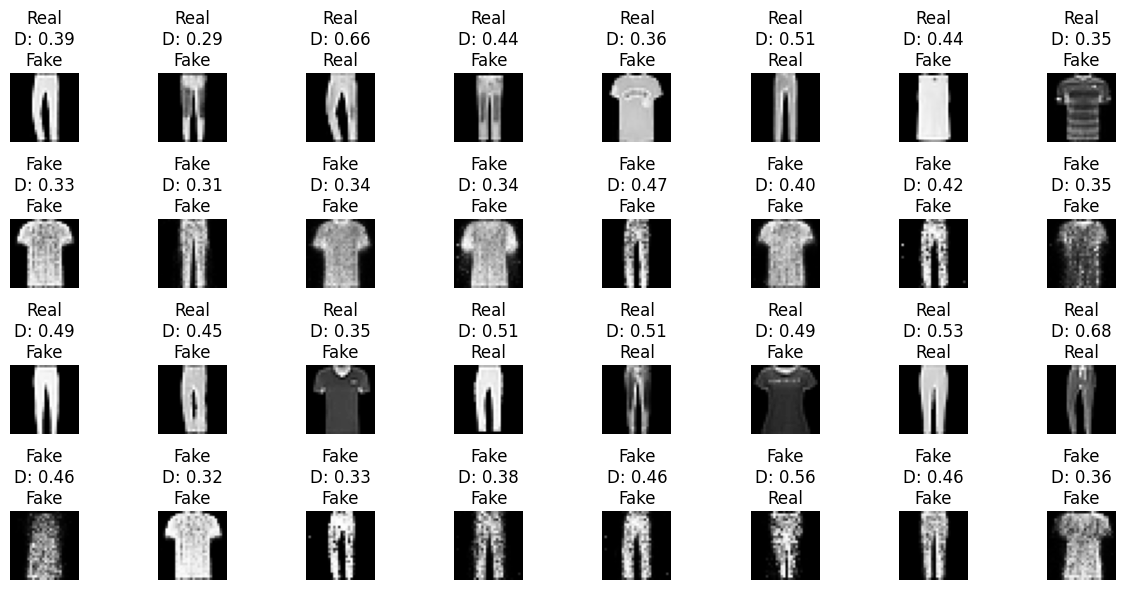

In [28]:
# Function to visualize real and fake images with classification
def visualize_results(generator, discriminator, test_loader, device):
    generator.eval()
    discriminator.eval()
    
    # Get a batch of real images
    real_images, real_labels = next(iter(test_loader))
    real_images, real_labels = real_images.to(device), real_labels.to(device)
    
    # Generate a batch of fake images
    z = torch.randn(real_images.size(0), noise_dim, device=device)
    fake_labels = torch.randint(0, num_classes, (real_images.size(0),), device=device)
    fake_images = generator(z, fake_labels)
    
    # Get discriminator predictions
    real_preds = discriminator(real_images, real_labels).detach().cpu().numpy().flatten()
    fake_preds = discriminator(fake_images, fake_labels).detach().cpu().numpy().flatten()
    
    # Visualize real and fake images
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i in range(8):
        axes[0, i].imshow(real_images[i, 0].cpu().detach().numpy(), cmap='gray')
        real_class = 'Real' if real_preds[i] > 0.5 else 'Fake'
        axes[0, i].set_title(f"Real\nD: {real_preds[i]:.2f}\n{real_class}")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(fake_images[i, 0].cpu().detach().numpy(), cmap='gray')
        fake_class = 'Real' if fake_preds[i] > 0.5 else 'Fake'
        axes[1, i].set_title(f"Fake\nD: {fake_preds[i]:.2f}\n{fake_class}")
        axes[1, i].axis('off')
    
    for i in range(8, 16):
        axes[2, i-8].imshow(real_images[i, 0].cpu().detach().numpy(), cmap='gray')
        real_class = 'Real' if real_preds[i] > 0.5 else 'Fake'
        axes[2, i-8].set_title(f"Real\nD: {real_preds[i]:.2f}\n{real_class}")
        axes[2, i-8].axis('off')
        
        axes[3, i-8].imshow(fake_images[i, 0].cpu().detach().numpy(), cmap='gray')
        fake_class = 'Real' if fake_preds[i] > 0.5 else 'Fake'
        axes[3, i-8].set_title(f"Fake\nD: {fake_preds[i]:.2f}\n{fake_class}")
        axes[3, i-8].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the results
visualize_results(generator, discriminator, test_loader, device)


Pada bagian ini, saya membuat fungsi visualize_results untuk memvisualisasikan gambar asli dan gambar palsu yang dihasilkan oleh Generator, bersama dengan prediksi dari Discriminator. Fungsi ini mengambil batch gambar asli dari test_loader dan menghasilkan gambar palsu menggunakan noise acak dan label acak. Kemudian, saya mendapatkan prediksi Discriminator untuk setiap gambar asli dan palsu, dan menampilkannya dalam grid menggunakan Matplotlib. Setiap gambar diberi judul dengan skor Discriminator dan kelas yang diprediksi (Real atau Fake). Pada gambar yang dihasilkan menunjukkan bahwa Discriminator mampu membedakan antara gambar asli dan palsu dengan skor yang cukup akurat. Pada beberapa kasus, gambar palsu dinilai sebagai "Real" dengan skor tinggi, menunjukkan bahwa Generator berhasil menghasilkan gambar yang realistis. Namun, beberapa gambar palsu masih terdeteksi dengan skor rendah, menandakan bahwa masih ada ruang untuk perbaikan pada Generator. Secara keseluruhan, visualisasi ini membantu dalam memahami performa model GAN dalam menghasilkan gambar yang mirip dengan data asli.








# C. Video

https://drive.google.com/file/d/1vyEheblKIiQD5Gk_6G51GO0srI6uVVau/view?usp=sharing